# Example using unseen PDF Image

In [1]:
import codecs, json, re, os, base64
import pandas as pd

from io import BytesIO
from PIL import Image
from IPython.display import HTML, display
from typing import Any
from datasets import load_dataset, Dataset


In [2]:
def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings
    :param pil_image: PIL image
    :return: Re-sized Base64 string"""
    
    if pil_image.mode in ("RGBA", "P"):
        pil_image = pil_image.convert("RGB")
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image
    :param img_base64: Base64 string
    """
    #create an HTML img tag w/ base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}"/>'
    #display the image by rendering HTML
    display(HTML(image_html))


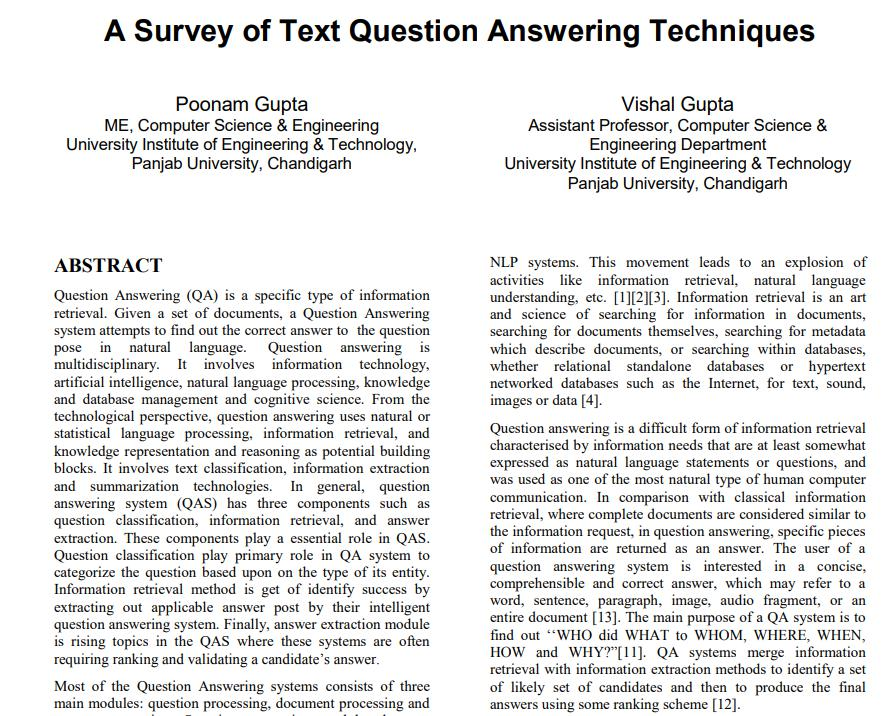

In [3]:
image = Image.open("UTF-8q1.png")
base64_img = convert_to_base64(image)
plt_img_base64(base64_img)

In [4]:
import torch 
import torch.nn as nn 
device = torch.device("cuda")

import transformers
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

2025-04-28 09:07:13.112668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 09:07:13.124222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745852833.137795   17369 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745852833.141573   17369 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745852833.151812   17369 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
checkpoint = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
def inference(image_path, prompt, sys_prompt="You are a helpful assistant.", max_new_tokens=150, return_input=False):
    image = Image.open(image_path)
    # image_local_path = "file://" + image_path
    try:
        messages = [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": [
                    {"type": "text", "text": prompt},
                    {"image": image},
                ]
            },
        ]
    
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        print("text:", text)
        # image_inputs, video_inputs = process_vision_info([messages])
        inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
        inputs = inputs.to('cuda')

        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
        generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
        output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if return_input:
            return output_text[0], inputs
        else:
            return output_text[0]
    except: 
        return ""

In [7]:
import time 

start = time.time()
prompt = f'''Use the image provided to answer the following question: What is the topic of the paper?. Keep the answer concise and limited to one sentence.'''
response = inference(
    image_path="UTF-8q1.png",
    prompt=prompt
    )
print(response)
end = time.time()
print("Inference Run Time: ", end-start)

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Use the image provided to answer the following question: What is the topic of the paper?. Keep the answer concise and limited to one sentence.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

The topic of the paper is a survey of text question answering techniques.
Inference Run Time:  1.242398977279663
